# Preparations

In [20]:
!pip install sktime

In [21]:
import os
import json
import zipfile
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")


In [22]:
# Step 1: Connect to Google Drive
# drive.mount('/content/drive')

## Functions

In [23]:
def plot_ts(time_data,plot_data,title_ts=""):
  fig, ax = plt.subplots(figsize=(20, 5))

  # Plot the data
  ax.plot(time_data,plot_data)

  # Set the primary x-axis for months
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

  # Add the secondary x-axis for years in the middle of the year
  sec_ax = ax.secondary_xaxis("bottom")
  sec_ax.xaxis.set_major_locator(mdates.YearLocator())
  sec_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  sec_ax.tick_params(axis='x', which='major', pad=20)

  # Labeling and title
  ax.set_ylabel('Number of Rides')
  ax.set_title(title_ts)
  sec_ax.set_xlabel('Time')

  # Display the grid and the plot
  ax.grid(True)
  plt.show()

def compare_ts(time_data, series1, series2, label1, label2, title_ts=""):
    fig, ax1 = plt.subplots(figsize=(20, 5))

    # Plot series1 on the left y-axis
    line1, = ax1.plot(time_data, series1, color='blue', label=label1)
    ax1.set_ylabel(label1, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Set the primary x-axis for months
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

    # Add the secondary x-axis for years
    sec_ax = ax1.secondary_xaxis("bottom")
    sec_ax.xaxis.set_major_locator(mdates.YearLocator())
    sec_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    sec_ax.tick_params(axis='x', which='major', pad=20)
    sec_ax.set_xlabel('Time')

    # Create a twin axis for the right y-axis
    ax2 = ax1.twinx()
    line2, = ax2.plot(time_data, series2, color='orange', label=label2)
    ax2.set_ylabel(label2, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Set title and grid
    ax1.set_title(title_ts)
    ax1.grid(True)

    # Combine legends for both plots
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left")

    # Adjust layout
    fig.tight_layout()
    plt.show()

def error_metrics(real, pred):
  mae = mean_absolute_error(real, pred)
  mse = mean_squared_error(real, pred)
  mape = mean_absolute_percentage_error(real, pred)
  smape = mean_absolute_percentage_error(real, pred, symmetric=True)
  r2 = r2_score(real, pred)  # Calculate R-squared

  # Print results
  print(f"Mean Absolute Error (MAE): {mae:.2f}")
  print(f"Mean Squared Error (MSE): {mse:.2f}")
  print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%")
  print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape*100:.2f}%")
  print(f"R-squared (R²): {r2:.4f}")  # Display R-squared

## Load Data

### Airport Arrivals

In [24]:
!ls -lh "/content/drive/Shared drives/Time Series"

total 18K
-rw------- 1 root root  183 Feb 13 20:21 'Brainstorming & Research.gdoc'
drwx------ 2 root root 4.0K Feb  7 20:48  divvy_data
-rw------- 1 root root  183 Feb 13 22:11 'Draft Proposal & Project Notes.gdoc'
-rw------- 1 root root  183 Feb 13 22:15 'Meeting Agenda.gdoc'
drwx------ 2 root root 4.0K Feb  7 21:32  Notebooks
drwx------ 2 root root 4.0K Feb 11 21:15  other_data
drwx------ 2 root root 4.0K Feb  9 20:02  weather_data


In [25]:
arrival_raw = pd.read_csv("/content/drive/Shared drives/Time Series/other_data/airport_arrivals_ord_UA.csv")
print(arrival_raw.shape)
arrival_raw.head()

(314132, 17)


,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Origin Airport,Scheduled Arrival Time,Actual Arrival Time,Scheduled Elapsed Time (Minutes),Actual Elapsed Time (Minutes),Arrival Delay (Minutes),Wheels-on Time,Taxi-In time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes)
0,UA,1/1/2020,203,N850UA,FAT,13:08,12:56,241,236,-12,12:45,11,0,0,0,0,0
1,UA,1/1/2020,210,N486UA,MCI,10:36,10:28,101,101,-8,10:01,27,0,0,0,0,0
2,UA,1/1/2020,214,N75858,SFO,6:00,6:09,241,251,9,5:58,11,0,0,0,0,0
3,UA,1/1/2020,218,N773UA,HNL,4:55,4:46,475,471,-9,4:38,8,0,0,0,0,0
4,UA,1/1/2020,219,N27477,DFW,8:06,7:43,141,121,-23,7:39,4,0,0,0,0,0


In [26]:
arrival_raw = arrival_raw.rename(columns={
    'Carrier Code': 'carrier',
    'Date (MM/DD/YYYY)': 'date',
    'Flight Number': 'flight_no',
    'Tail Number': 'tail_no',
    'Origin Airport': 'origin',
    'Scheduled Arrival Time': 'sched_arrival',
    'Actual Arrival Time': 'actual_arrival',
    'Scheduled Elapsed Time (Minutes)': 'sched_elapsed',
    'Actual Elapsed Time (Minutes)': 'actual_elapsed',
    'Arrival Delay (Minutes)': 'arrival_delay',
    'Wheels-on Time': 'wheels_on',
    'Taxi-In time (Minutes)': 'taxi_in',
    'Delay Carrier (Minutes)': 'delay_carrier',
    'Delay Weather (Minutes)': 'delay_weather',
    'Delay National Aviation System (Minutes)': 'delay_nas',
    'Delay Security (Minutes)': 'delay_security',
    'Delay Late Aircraft Arrival (Minutes)': 'delay_late_aircraft'
})
arrival_raw.head()

,carrier,date,flight_no,tail_no,origin,sched_arrival,actual_arrival,sched_elapsed,actual_elapsed,arrival_delay,wheels_on,taxi_in,delay_carrier,delay_weather,delay_nas,delay_security,delay_late_aircraft
0,UA,1/1/2020,203,N850UA,FAT,13:08,12:56,241,236,-12,12:45,11,0,0,0,0,0
1,UA,1/1/2020,210,N486UA,MCI,10:36,10:28,101,101,-8,10:01,27,0,0,0,0,0
2,UA,1/1/2020,214,N75858,SFO,6:00,6:09,241,251,9,5:58,11,0,0,0,0,0
3,UA,1/1/2020,218,N773UA,HNL,4:55,4:46,475,471,-9,4:38,8,0,0,0,0,0
4,UA,1/1/2020,219,N27477,DFW,8:06,7:43,141,121,-23,7:39,4,0,0,0,0,0


In [27]:
arrival_raw["date"] = pd.to_datetime(arrival_raw["date"])
arrival_raw.sort_values("date",inplace=True)
arrival_raw.head()

,carrier,date,flight_no,tail_no,origin,sched_arrival,actual_arrival,sched_elapsed,actual_elapsed,arrival_delay,wheels_on,taxi_in,delay_carrier,delay_weather,delay_nas,delay_security,delay_late_aircraft
0,UA,2020-01-01,203,N850UA,FAT,13:08,12:56,241,236,-12,12:45,11,0,0,0,0,0
117,UA,2020-01-01,1546,N35407,MCO,9:13,9:22,178,189,9,9:20,2,0,0,0,0,0
118,UA,2020-01-01,1562,N36272,ANC,5:20,5:14,358,353,-6,5:10,4,0,0,0,0,0
119,UA,2020-01-01,1572,N67845,PHL,14:51,14:32,145,131,-19,14:18,14,0,0,0,0,0
120,UA,2020-01-01,1611,N13227,EWR,22:05,22:00,155,148,-5,21:55,5,0,0,0,0,0


In [28]:
tmp = arrival_raw.groupby("date")["carrier"].count().reset_index().sort_values("date")
print(tmp.shape)
tmp.head()

(1766, 2)


,date,carrier
0,2020-01-01,183
1,2020-01-02,194
2,2020-01-03,197
3,2020-01-04,179
4,2020-01-05,196


In [29]:
tmp.tail()

,date,carrier
1761,2024-10-27,249
1762,2024-10-28,255
1763,2024-10-29,238
1764,2024-10-30,236
1765,2024-10-31,238


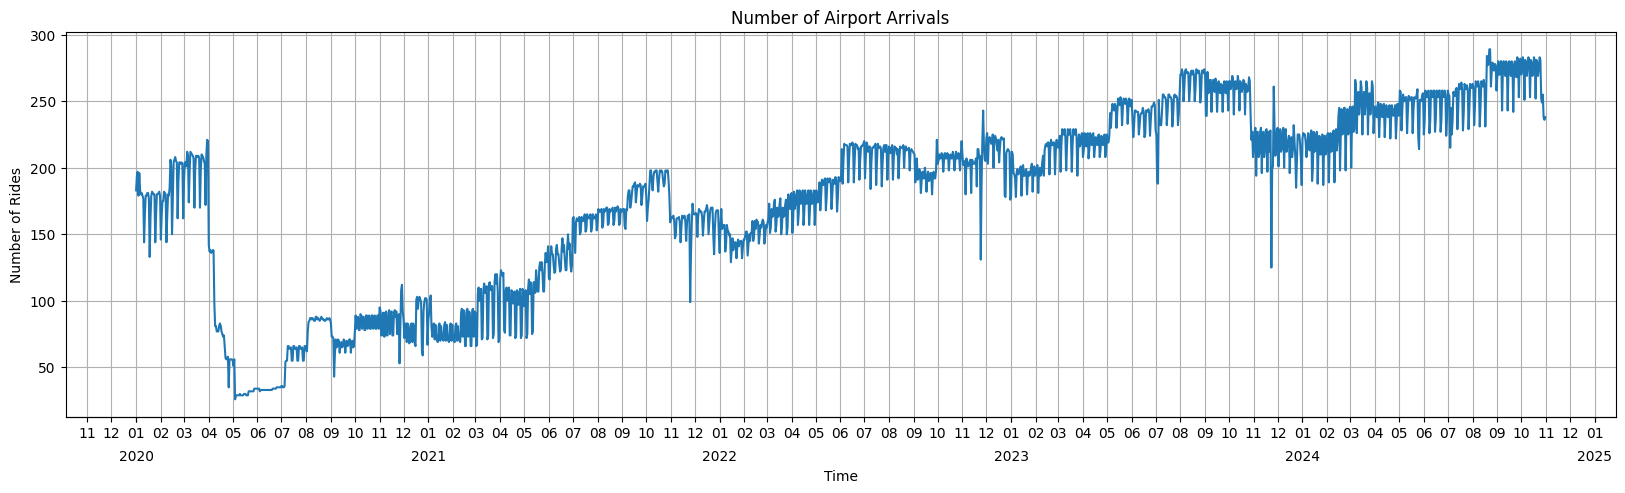

In [30]:
plot_ts(tmp["date"],tmp["carrier"],"Number of Airport Arrivals")

# Gas Prices

In [33]:
drive.mount('/content/drive')
gas = pd.read_csv("/content/drive/Shared drives/Time Series/other_data/Weekly_Chicago_IL_Regular_Reformulated_Retail_Gasoline_Prices.csv")
gas.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Week of,Weekly Chicago IL Regular Reformulated Retail Gasoline Prices Dollars per Gallon
0,2/10/2025,3.329
1,2/3/2025,3.303
2,1/27/2025,3.361
3,1/20/2025,3.360
4,1/13/2025,3.324


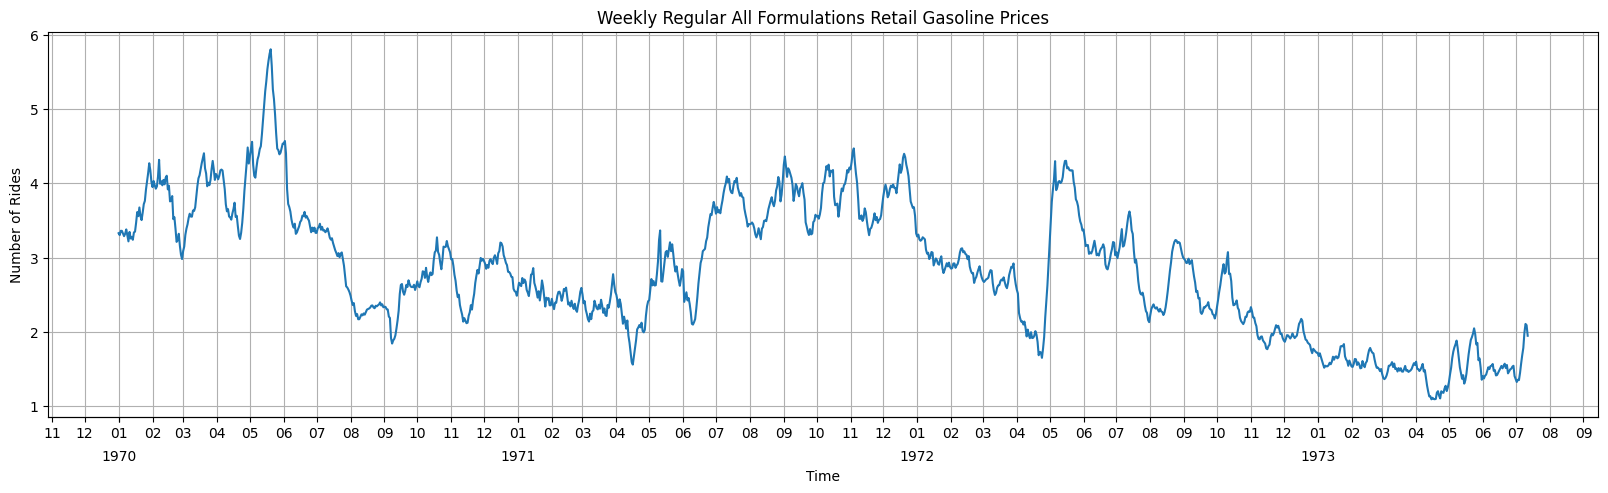

In [40]:
plot_ts(gas["Week of"],gas["Weekly Chicago IL Regular Reformulated Retail Gasoline Prices Dollars per Gallon"],"Weekly Regular All Formulations Retail Gasoline Prices")